In [10]:
from sklearn.linear_model import RANSACRegressor
import open3d as o3d
import copy
import os
import json
from glob import glob
import torch
from my_lib import ROOT
import my_lib
import scipy
from torch_geometric.data import Data
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot



In [11]:
data_dir=os.path.join(ROOT,'data','raw','test')
# with open(data_dir) as f:
#     data = json.load(f)
data={}
files=glob(data_dir + '/*.json')
for file in files:
    print(file)
    filename=file.split(os.sep)[-1].split('.')[0]
    with open(file,'r') as f:
        tmp = json.load(f)

    data.update({filename:tmp})

print(data.keys())


C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube-like_1.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube-like_2.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\cube.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\dod-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\dod.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\oct-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\oct.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\rotated_tetra.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\scaled_tetra.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\tetra-like.json
C:\Users\lllang\Desktop\side_projects\pyg\data\raw\test\tetra.json
dict_keys(['cube-like_1', 'cube-like_2', 'cube', 'dod-like', 'dod', 'oct-like', 'oct', 'rotated_tetra', 'scaled_tetra', 'tetra-like', 'tetra'])


# Visualize poly

In [12]:
import pyvista as pv
# pv.set_jupyter_backend('panel')  
# pv.set_jupyter_backend('ipyvtklink')
# pv.set_jupyter_backend('ipygany')
pv.set_jupyter_backend('trame')  
# pv.set_jupyter_backend(None)  
class PolyPlotter:
    def __init__(self):
        self.p=pv.Plotter()

    def add_poly(self,vertices,**kwargs):
        self.p.add_mesh(vertices,**kwargs)

    def show(self):
        self.p.show()
        # self.p.show(jupyter_backend='client')

In [13]:
plotter=PolyPlotter()
plotter.add_poly(vertices=np.array(data['cube']['vertices']), render_points_as_spheres=True,color='red')
plotter.add_poly(vertices=my_lib.math.rot_z(np.array(data['cube']['vertices']),45 ) , render_points_as_spheres=True,color='blue')
plotter.p.show_axes()
plotter.p.show_grid()
# plotter.p.show_bounds(
#     grid='front',
#     location='outer',
#     all_edges=True,
# )

<CubeAxesActor(0x000002491F04AA40) at 0x000002491C0E3280>

In [14]:
plotter.show()

Widget(value="<iframe src='http://localhost:53526/index.html?ui=P_0x2492bd7beb0_1&reconnect=auto' style='width…

# Defining Useful functions

In [15]:
def plot_similarity_matrix( similarity_matrix, labels, add_values=True, filename=None):
    fig, ax = plt.subplots()
    cax = ax.matshow(similarity_matrix, cmap='coolwarm')  # Change the color map here
    fig.colorbar(cax)

    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)

    fig.suptitle('Similarity matrix')

    if add_values:
        for i in range(similarity_matrix.shape[0]):
            for j in range(similarity_matrix.shape[1]):
                ax.text(j, i, format(similarity_matrix[i, j], ".2f"), 
                        ha="center", va="center", 
                        color="w" if np.abs(similarity_matrix[i, j]) > 0.5 else "black")
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [16]:
def ransac(x, y,**kwargs):
    ransac = RANSACRegressor(**kwargs)
    ransac.fit(x, y)
    return ransac.estimator_


In [17]:
dgm1 = np.array(data['cube']['vertices'])
dgm2 = np.array(data['tetra']['vertices'])
rotated_dgm1=my_lib.math.rot_z(dgm1,45)

In [18]:
reg=ransac(dgm1, rotated_dgm1)
reg.score(dgm1, rotated_dgm1)


reg=ransac(dgm1, dgm2)
reg.score(dgm1, dgm2)

ValueError: Found input variables with inconsistent numbers of samples: [8, 4]

# Procrustes analysis

a similarity test for two data sets.

Each input matrix is a set of points or vectors (the rows of the matrix). The dimension of the space is the number of columns of each matrix. Given two identically sized matrices, procrustes standardizes both such that:

.

Both sets of points are centered around the origin.

Procrustes ([1], [2]) then applies the optimal transform to the second matrix (including scaling/dilation, rotations, and reflections) to minimize 
, or the sum of the squares of the pointwise differences between the two input datasets.

This function was not designed to handle datasets with different numbers of datapoints (rows). If two data sets have different dimensionality (different number of columns), simply add columns of zeros to the smaller of the two.

In [ ]:
# def equalize_point_clouds(pc1, pc2):
#     num_points_pc1 = pc1.shape[0]
#     num_points_pc2 = pc2.shape[0]

#     if num_points_pc1 < num_points_pc2:
#         points_to_add = num_points_pc2 - num_points_pc1
#         pc1 = np.vstack([pc1, np.zeros((points_to_add, pc1.shape[1]))])
#     elif num_points_pc2 < num_points_pc1:
#         points_to_add = num_points_pc1 - num_points_pc2
#         pc2 = np.vstack([pc2, np.zeros((points_to_add, pc2.shape[1]))])

#     return pc1, pc2
def equalize_point_clouds(pc1, pc2):
    num_points_pc1 = pc1.shape[0]
    num_points_pc2 = pc2.shape[0]

    if num_points_pc1 < num_points_pc2:
        points_to_add = num_points_pc2 - num_points_pc1
        pc1 = np.vstack([pc1, np.repeat(pc1[-1, :][np.newaxis, :], points_to_add, axis=0)])
    elif num_points_pc2 < num_points_pc1:
        points_to_add = num_points_pc1 - num_points_pc2
        pc2 = np.vstack([pc2, np.repeat(pc2[-1, :][np.newaxis, :], points_to_add, axis=0)])

    return pc1, pc2

In [ ]:
dgm1 = np.array(data['cube']['vertices'])
dgm2 = np.array(data['tetra']['vertices'])
rotated_dgm1=my_lib.math.rot_z(dgm1,45)
print(dgm1.shape, dgm2.shape)
pc1, pc2= equalize_point_clouds(dgm1, dgm2)
print(pc1.shape, pc2.shape)

(8, 3) (4, 3)
(8, 3) (8, 3)


In [ ]:
mtx1, mtx2, disparity = scipy.spatial.procrustes(pc1, pc2)
print(disparity)


mtx1, mtx2, disparity = scipy.spatial.procrustes(dgm1, rotated_dgm1)
print(disparity)

0.5592974013692504
8.936314941956774e-32


In [ ]:

shape_names=list(data.keys())
for i,name in enumerate(shape_names):
    print(name,i)
print(shape_names)
custom_names_index=[0,1,3,5,9,7,8,10,2,6,4]
shape_names_custom=[shape_names[i] for i in custom_names_index  ]
n_shapes=len(shape_names_custom)
similarity_matrix=np.zeros(shape=(n_shapes,n_shapes))
for i,shape_name_i in enumerate(shape_names_custom):
    for j,shape_name_j in enumerate(shape_names_custom):
        point_set_1=np.array(data[shape_name_i]['vertices'])
        point_set_2=np.array(data[shape_name_j]['vertices'])
        point_set_1, point_set_2= equalize_point_clouds(point_set_1, point_set_2)
        mtx1, mtx2, disparity = scipy.spatial.procrustes(point_set_1, point_set_2)
        similarity_matrix[i,j]=disparity

cube-like_1 0
cube-like_2 1
cube 2
dod-like 3
dod 4
oct-like 5
oct 6
rotated_tetra 7
scaled_tetra 8
tetra-like 9
tetra 10
['cube-like_1', 'cube-like_2', 'cube', 'dod-like', 'dod', 'oct-like', 'oct', 'rotated_tetra', 'scaled_tetra', 'tetra-like', 'tetra']


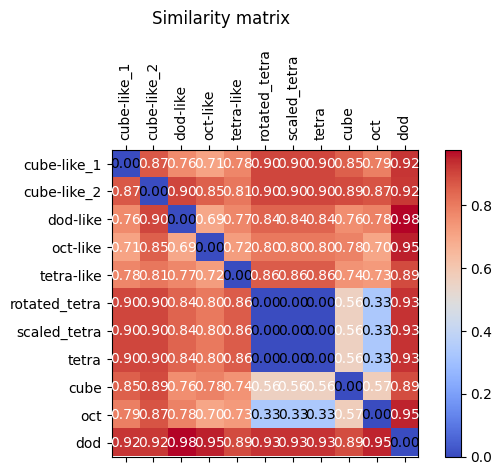

In [ ]:
plot_similarity_matrix( similarity_matrix, labels=shape_names_custom)

# ICP registration

This tutorial demonstrates the ICP (Iterative Closest Point) registration algorithm. It has been a mainstay of geometric registration in both research and industry for many years. The input are two point clouds and an initial transformation that roughly aligns the source point cloud to the target point cloud. The output is a refined transformation that tightly aligns the two point clouds. A helper function draw_registration_result visualizes the alignment during the registration process. In this tutorial, we show two ICP variants, the point-to-point ICP and the point-to-plane ICP [Rusinkiewicz2001].

In [ ]:
def draw_registration_result(source, target,transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    # source_temp.compute_vertex_normals()
    # target_temp.compute_vertex_normals()
    # zoom = np.array([0.4459])
    # front = np.array([0.9288, -0.2951, -0.2242])
    # lookat = np.array([1.6784, 2.0612, 1.4451])
    # up = np.array([-0.3402, -0.9189, -0.1996])
    source_temp.transform(transformation)

    o3d.visualization.draw_geometries([source_temp, target_temp])
                                    #   zoom=zoom,
                                    #   front=front,
                                    #   lookat=lookat,
                                    #   up=up)

In [ ]:
ps_1=np.array(data['cube']['vertices'])
ps_2=my_lib.math.rot_z(np.array(data['cube']['vertices']),45 )

print(ps_1)
print(ps_2)
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(ps_1)

target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(ps_2)

print(target, "\n")
threshold = 0.02

print(target.points)
print(source.points)
transform_init=np.asarray([[1., 0., 0., 0.],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
draw_registration_result(source, target,transform_init)

[[-0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5]
 [ 0.5  0.5  0.5]]
[[-0.70710678  0.         -0.5       ]
 [-0.70710678  0.          0.5       ]
 [ 0.          0.70710678 -0.5       ]
 [ 0.          0.70710678  0.5       ]
 [ 0.         -0.70710678 -0.5       ]
 [ 0.         -0.70710678  0.5       ]
 [ 0.70710678  0.         -0.5       ]
 [ 0.70710678  0.          0.5       ]]
PointCloud with 8 points. 

std::vector<Eigen::Vector3d> with 8 elements.
Use numpy.asarray() to access data.
std::vector<Eigen::Vector3d> with 8 elements.
Use numpy.asarray() to access data.


In [ ]:
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold)
print(evaluation)

Initial alignment
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


# Point-to-point ICP
In general, the ICP algorithm iterates over two steps:

Find correspondence set K={(p,q)}
 from target point cloud P
, and source point cloud Q
 transformed with current transformation matrix T
.

Update the transformation T
 by minimizing an objective function E(T)
 defined over the correspondence set K
.

Different variants of ICP use different objective functions E(T)
 [BeslAndMcKay1992] [ChenAndMedioni1992] [Park2017].

We first show a point-to-point ICP algorithm [BeslAndMcKay1992] using the objective

E(T)=∑(p,q)∈K∥p−Tq∥2

The class TransformationEstimationPointToPoint provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective. The function registration_icp takes it as a parameter and runs point-to-point ICP to obtain the results.

In [ ]:
ps_1=np.array(data['cube']['vertices'])
ps_2=my_lib.math.rot_z(np.array(data['cube']['vertices']),45 )

source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(ps_1)

target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(ps_2)

In [ ]:
print("Apply point-to-point ICP")

threshold = 50
transform_init=np.asarray([[1., 0., 0., 0.],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold,transform_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    # o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    # o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(),
    o3d.pipelines.registration.ICPConvergenceCriteria( relative_fitness=1.000000e-6, relative_rmse=1.000000e-6, max_iteration=10000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)


Apply point-to-point ICP
RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.097478e-01, and correspondence_set size of 8
Access transformation to get result.
Transformation is:
[[ 1.          0.          0.         -0.35355339]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [ ]:
draw_registration_result(source, target, reg_p2p.transformation)

In [ ]:
def similarity_o3d(ps_1,ps_2,threshold = 0.02):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(ps_1)

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(ps_2)

    evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold)
    print(evaluation)
    return evaluation

In [ ]:
ps_1=np.array(data['cube']['vertices'])
ps_2=np.array(data['tetra']['vertices'])

similarity_o3d(ps_1,ps_2,threshold = 0.02)

RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.

# Custom ICP

In [ ]:
def icp(a, b,
        max_time = 1
    ):
    import cv2
    import numpy
    import copy
    import pylab
    import time
    import sys
    import sklearn.neighbors
    import scipy.optimize



    def res(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = numpy.sum(numpy.square(d[:,0])+numpy.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],
                            [ numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = numpy.array([  numpy.sum(2*d[:,0]),
                        numpy.sum(2*d[:,1]),
                        numpy.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    def hess(p,src,dst):
        n = numpy.size(src,0)
        T = numpy.matrix([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],
        [numpy.sin(p[2]), numpy.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = numpy.size(src,0)
        xt = numpy.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = numpy.zeros(numpy.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = numpy.matrix([[-numpy.sin(p[2]),-numpy.cos(p[2])],[numpy.cos(p[2]),-numpy.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = numpy.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = numpy.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = numpy.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = numpy.matrix([[-numpy.cos(p[2]), numpy.sin(p[2])],[-numpy.sin(p[2]),-numpy.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = numpy.sum(2*(numpy.square(dUdth[:,0])+numpy.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    t0 = time.time()
    init_pose = (0,0,0)
    src = numpy.array([a.T], copy=True).astype(numpy.float32)
    dst = numpy.array([b.T], copy=True).astype(numpy.float32)
    Tr = numpy.array([[numpy.cos(init_pose[2]),-numpy.sin(init_pose[2]),init_pose[0]],
                   [numpy.sin(init_pose[2]), numpy.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",numpy.shape(src))
    print("Tr[0:2]",numpy.shape(Tr[0:2]))
    src = cv2.transform(src, Tr[0:2])
    p_opt = numpy.array(init_pose)
    T_opt = numpy.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = numpy.array([[numpy.cos(p[2]),-numpy.sin(p[2]),p[0]],[numpy.sin(p[2]), numpy.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*numpy.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv2.transform(src, T)
        Tr = (numpy.matrix(numpy.vstack((T,[0,0,1])))*numpy.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*numpy.pi)
    return T_opt, error_max

In [ ]:
# import cv2
# import numpy
# import random
# import matplotlib.pyplot
# n1 = 100
# n2 = 75
# bruit = 1/10
# center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
# radius = random.random()
# deformation = 2

# template = numpy.array([
#     [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
#     [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
# ])

# data = numpy.array([
#     [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
#     [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
# ])

# T,error = icp(data,template)
# dx = T[0,2]
# dy = T[1,2]
# rotation = numpy.arcsin(T[0,1]) * 360 / 2 / numpy.pi

# print("T",T)
# print("error",error)
# print("rotation°",rotation)
# print("dx",dx)
# print("dy",dy)

# result = cv2.transform(numpy.array([data.T], copy=True).astype(numpy.float32), T).T
# matplotlib.pyplot.plot(template[0], template[1], label="template")
# matplotlib.pyplot.plot(data[0], data[1], label="data")
# matplotlib.pyplot.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
# matplotlib.pyplot.legend(loc="upper left")
# matplotlib.pyplot.axis('square')
# matplotlib.pyplot.show()

In [ ]:
print(data)
ps_1=np.asarray(data['cube']['vertices'])
ps_2=np.asarray(data['tetra']['vertices'])

T,error = icp(ps_1, ps_2,max_time = 1)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

{'cube-like_1': {'vertices': [[-1.5610940596101637, 3.007591755096396, 0.6540881713940931], [-0.12734937191639875, 1.5018256393814862, -0.9681590877898649], [-0.1472139553524771, 4.059347306539453, 0.9048358963742741], [-1.1056018594606634, 2.9118447037721467, -1.2628776782671443], [-1.1347728981648033, 2.9395716377943497, -1.2192138009483693], [-1.1007870284255312, 2.954760759147764, -1.2642544002698246], [0.14721395535247794, 1.4480816934605474, -0.9048358963742734], [-0.04951849136340658, 1.3380790861342804, -0.7558287522527248], [1.1007870284255317, 2.5526682408522365, 1.2642544002698248], [-0.4467834459029587, 1.4014632463672834, 0.9897970580129993], [0.0495184913634068, 4.1693499138657195, 0.7558287522527258], [1.1056018594606638, 2.5955842962278535, 1.2628776782671451], [0.12734937191639872, 4.005603360618514, 0.9681590877898655], [0.44678344590295893, 4.105965753632717, -0.9897970580129986], [1.1347728981648038, 2.5678573622056504, 1.219213800948371], [1.5610940596101637, 2.499

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:458: error: (-215:Assertion failed) scn == m.cols || scn + 1 == m.cols in function 'cv::transform'


# Open CIV ICP

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between two 3D point sets.
    Input:
        A: nx3 numpy array of corresponding points
        B: nx3 numpy array of corresponding points
    Returns:
        T: 4x4 homogeneous transformation matrix
        R: 3x3 rotation matrix
        t: 3x1 column vector
    '''

    assert len(A) == len(B)

    num_rows, num_cols = A.shape;

    if num_cols != 3:
        raise 'dimension of the points must be 3'

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[num_rows-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t

def nearest_neighbor(src, dst):
    '''
    Find the nearest neighbors between two sets of points
    Input:
        src: nx3 numpy array of points
        dst: mx3 numpy array of points
    Returns:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert len(src)

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)

    return distances.ravel(), indices.ravel()

def equalize_point_cloud_sizes(A, B):
    if A.shape[0] < B.shape[0]:
        last_point = A[-1, :]
        num_points_to_add = B.shape[0] - A.shape[0]
        A = np.vstack([A] + [last_point] * num_points_to_add)
    elif B.shape[0] < A.shape[0]:
        last_point = B[-1, :]
        num_points_to_add = A.shape[0] - B.shape[0]
        B = np.vstack([B] + [last_point] * num_points_to_add)
    return A, B

def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src[:m,:] = np.dot(init_pose, src)[:m,:]

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src[:m,:] = (np.dot(T[:m,:m], src[:m,:]) + T[:m,m].reshape(-1,1)).reshape(m, -1)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, distances, i

In [ ]:
# Example of usage with a 3D cube and a tetrahedron

# Create a cube
cube = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 1, 1]
])

# Create a tetrahedron
tetrahedron = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [0.5, 0.5 * np.sqrt(3), 0],
    [0.5, 0.5 / np.sqrt(3), np.sqrt(2/3)]
])

# Equalize point clouds sizes
cube, tetrahedron = equalize_point_cloud_sizes(cube, tetrahedron)

# Apply ICP
T, distances, iterations = icp(cube, tetrahedron)

print("Transformation matrix:")
print(T)

print(f"Mean error: {np.mean(distances):.2f}")
print(f"Iterations: {iterations}")


Transformation matrix:
[[ 1.          0.          0.          0.        ]
 [ 0.          0.99339413 -0.11475232 -0.07847699]
 [ 0.          0.11475232  0.99339413 -0.14582494]
 [ 0.          0.          0.          1.        ]]
Mean error: 0.52
Iterations: 2


In [ ]:
# Equalize point clouds sizes
ps_1=np.array(data['cube']['vertices'])
# ps_2=np.array(data['tetra']['vertices'])
ps_2=my_lib.math.rot_z(ps_1,45)
ps_1, ps_2 = equalize_point_cloud_sizes(ps_1, ps_2)

# Apply ICP
T, distances, iterations = icp(ps_1, ps_2,max_iterations=20, tolerance=0.0000001)

print("Transformation matrix:")
print(T)

print(f"Mean error: {np.mean(distances):.2f}")
print(f"Iterations: {iterations}")


Transformation matrix:
[[ 1.          0.          0.         -0.35355339]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
Mean error: 0.39
Iterations: 2


In [27]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial import KDTree
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A and B.
    '''
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = np.dot(AA.T, BB)

    U, S, Vt = np.linalg.svd(H)

    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
       Vt[-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    t = centroid_B.T - np.dot(R,centroid_A.T)

    return R, t


def icp(A, B, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: aligns points in dataset A to dataset B.
    '''
    src = np.array([A.T], copy=True).astype(float)
    dst = np.array([B.T], copy=True).astype(float)

    prev_error = 0

    for i in range(max_iterations):
        # Find the nearest neighbours between the current source and destination points
        distances, indices = KDTree(dst[0].T).query(src[0].T)

        # Compute the transformation between the current source and nearest destination points
        R, t = best_fit_transform(src[0].T, dst[0, indices].T)

        # Update the current source
        src[0] = np.dot(R, src[0]) + t

        # Check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # Compute the final transformation
    R, t = best_fit_transform(A, src[0].T)

    return R, t


In [28]:
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation as R
import math

# Define the vertices for the cube and the tetrahedra point clouds
cube = np.array([(0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1)])
tetrahedra = np.array([(0,0,0), (1,0,0), (0.5, math.sqrt(3)/2, 0), (0.5, math.sqrt(3)/6, math.sqrt(2/3))]) + 5

# Run the ICP algorithm
rotation, translation = icp(cube, tetrahedra)
print("Rotation Matrix: ", rotation)
print("Translation: ", translation)

# Apply the ICP transformation to the tetrahedra
aligned_tetrahedra = np.dot(rotation, tetrahedra.T).T + translation

print('Aligned Tetrahedra Points:')
print(aligned_tetrahedra)

ValueError: shapes (3,8) and (4,8) not aligned: 8 (dim 1) != 4 (dim 0)

In [ ]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def calculate_similarity(point_cloud1, point_cloud2):
    # Convert the point clouds to numpy arrays
    point_cloud1 = np.array(point_cloud1)
    point_cloud2 = np.array(point_cloud2)

    # Calculate the directed Hausdorff distances
    hd1 = directed_hausdorff(point_cloud1, point_cloud2)[0]
    hd2 = directed_hausdorff(point_cloud2, point_cloud1)[0]

    # The Hausdorff distance is the maximum of these two distances
    hausdorff_distance = max(hd1, hd2)

    return hausdorff_distance

# Example usage:
point_cloud1 = [[0, 0, 0], [1, 1, 1], [2, 2, 2]]
point_cloud2 = [[0, 0, 0], [1, 1, 1], [3, 3, 3]]
print(calculate_similarity(point_cloud1, point_cloud2))